<a href="https://colab.research.google.com/github/pavel7479/For_resume/blob/main/%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B5%D0%B7%D1%83%D0%BB%D1%8C%D1%82%D0%B0%D1%82%D0%BE%D0%B2%20%D1%84%D1%83%D1%82%D0%B1%D0%BE%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20_%20%D0%BC%D0%B0%D1%82%D1%87%D0%B5%D0%B9_%D1%82%D1%80%D0%B8_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8_LogisticRegression%2C_Dense%2C_LSTM_%D1%81%D0%BB%D0%BE%D1%8F%D0%BC%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Есть результаты футбольных матчей чемпионта Италии по футболу с 2011 года. Задача сделать нейросеть которая предсказывала бы результаты текущего чемпионата, что бы упростить задачу НС должна предсказать не проиграет ли команда которая играет дома, т.е у нас два результата проигрыш и не проигрыш (ничья или выигрышь не важно). Тестировать НС предлагаю на чемпионате Испании т.к. уровень чемпионатов одинаков, менталитет стран похож.

FTHG и HG = Цели домашней команды на полный рабочий день FTAG и AG = Цели команды на выезде на полное время FTR и Res = результат основного времени (H = победа дома, D = ничья, A = победа в гостях) HTHG = Голы домашней команды в первом тайме HTAG = Командные голы в перерыве между таймами HTR = результат первого тайма (H=победа хозяев, D=ничья, A=победа гостей) HS = удары домашней команды AS = Командные броски в гостях HST = Удары домашней команды в створ AST = Удары команды гостей в створ HHW = Домашняя команда попала в столярку AHW = Гостиная команда попала в столярку HC = Домашние угловые команды AC = Угловые команды гостей HF = Совершенные фолы домашней команды AF = Совершены фолы команды гостей HFKC = Пропущенные штрафные удары домашней команды AFKC = Пропущенные штрафные удары команды гостей HO = офсайды домашней команды AO = Офсайды команды гостей HY = Желтые карточки домашней команды AY = Желтые карточки для команды гостей HR = Красные карточки домашней команды AR = Красные карточки гостевой команды

In [ ]:
# @title Загрузка библиотек
import os
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LogisticRegression

# Подготовка БД любого размера

**База данных для обучения строиться на основе чемпионатов Италии**

In [ ]:
# @title Подготовка объединённой таблицы

# Задайте путь к директории, которую нужно просканировать
directory_path = '/content/Italiy/'

# Список столбцов, которые нужно оставить
columns_to_keep = ['Date',	'HomeTeam',	'AwayTeam',	'FTHG',	'FTAG',	'FTR',	'HTHG',	'HTAG',	'HTR',	'HS',	'AS',	'HST',	'AST',
                   'HF',	'AF',	'HC',	'AC',	'HY',	'AY',	'HR',	'AR']

# Получите список всех файлов в директории
file_list = os.listdir(directory_path)

# Создаём объеденённую таблицу
df_join = []
df_join = pd.DataFrame(df_join)
# Переберите все файлы и выполните нужные действия
for file_name in file_list:
    # Получите полный путь к файлу
    file_path = os.path.join(directory_path, file_name)

    # Проверяем, является ли файл
    if os.path.isfile(file_path):
        # читаем файл
        data = pd.read_csv(file_path, encoding='cp1251', delimiter=',')
        # переводим в DataFrame
        df = pd.DataFrame(data)
        # переводим в DataFrame
        df = pd.DataFrame(data)
        # оставляем нужные колонки
        df = df.drop(columns=df.columns.difference(columns_to_keep))
        # Объединение данных всех таблиц
        df_join = pd.concat([df_join, df])
    else:
        print(f"{file_name} не является файлом данных и будет пропущен.")

# Вывод объединенной таблицы
print(df_join)
print(df_join.shape)


           Date   HomeTeam  AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR    HS  \
0      24/08/13  Sampdoria  Juventus   0.0   1.0   A   0.0   0.0   D   4.0   
1      24/08/13     Verona     Milan   2.0   1.0   H   1.0   1.0   D  14.0   
2      25/08/13   Cagliari  Atalanta   2.0   1.0   H   1.0   1.0   D  23.0   
3      25/08/13      Inter     Genoa   2.0   0.0   H   0.0   0.0   D  20.0   
4      25/08/13      Lazio   Udinese   2.0   1.0   H   2.0   0.0   H  20.0   
..          ...        ...       ...   ...   ...  ..   ...   ...  ..   ...   
375  26/05/2019      Inter    Empoli   2.0   1.0   H   0.0   0.0   D  20.0   
376  26/05/2019       Roma     Parma   2.0   1.0   H   1.0   0.0   H  16.0   
377  26/05/2019  Sampdoria  Juventus   2.0   0.0   H   0.0   0.0   D  10.0   
378  26/05/2019       Spal     Milan   2.0   3.0   A   1.0   2.0   A   7.0   
379  26/05/2019     Torino     Lazio   3.0   1.0   H   0.0   0.0   D   9.0   

     ...   HST  AST    HF    AF    HC    AC   HY   AY   HR   AR

In [ ]:
# @title Выявим пропущенные значения и удалим их

# выявим пропущенные значения с помощью .isnull() и посчитаем их количество через sum()
print(df_join.isnull().sum())
print()
print()
# удаление пустых значений
df_join.dropna(inplace=True)
print(df_join.isnull().sum())

Date        5
HomeTeam    5
AwayTeam    5
FTHG        5
FTAG        5
FTR         5
HTHG        7
HTAG        7
HTR         7
HS          6
AS          6
HST         6
AST         6
HF          6
AF          6
HC          6
AC          6
HY          7
AY          6
HR          6
AR          6
dtype: int64


Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


In [ ]:
df_join[1000:1010]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
241,12/02/16,Carpi,Roma,1.0,3.0,A,0.0,0.0,D,7.0,...,2.0,6.0,14.0,8.0,4.0,6.0,5.0,0.0,0.0,0.0
242,13/02/16,Chievo,Sassuolo,1.0,1.0,D,1.0,1.0,D,11.0,...,4.0,2.0,16.0,14.0,5.0,7.0,3.0,2.0,0.0,0.0
243,13/02/16,Empoli,Frosinone,1.0,2.0,A,0.0,1.0,A,29.0,...,6.0,2.0,11.0,25.0,16.0,1.0,2.0,6.0,0.0,0.0
244,13/02/16,Juventus,Napoli,1.0,0.0,H,0.0,0.0,D,13.0,...,4.0,1.0,10.0,13.0,4.0,3.0,2.0,2.0,0.0,0.0
245,14/02/16,Fiorentina,Inter,2.0,1.0,H,0.0,1.0,A,13.0,...,8.0,1.0,13.0,14.0,7.0,4.0,2.0,5.0,1.0,2.0
246,14/02/16,Milan,Genoa,2.0,1.0,H,1.0,0.0,H,14.0,...,6.0,2.0,14.0,15.0,5.0,3.0,1.0,1.0,0.0,0.0
247,14/02/16,Palermo,Torino,1.0,3.0,A,1.0,2.0,A,18.0,...,5.0,8.0,12.0,22.0,9.0,3.0,1.0,2.0,0.0,0.0
248,14/02/16,Sampdoria,Atalanta,0.0,0.0,D,0.0,0.0,D,10.0,...,2.0,2.0,10.0,15.0,7.0,6.0,2.0,4.0,0.0,0.0
249,14/02/16,Udinese,Bologna,0.0,1.0,A,0.0,0.0,D,10.0,...,2.0,2.0,15.0,11.0,8.0,6.0,0.0,1.0,0.0,0.0
250,19/02/16,Bologna,Juventus,0.0,0.0,D,0.0,0.0,D,8.0,...,1.0,0.0,15.0,11.0,1.0,8.0,2.0,2.0,0.0,0.0


In [ ]:
# @title Удаляем столбец дата т.к. данные идут в порядке увеличения дат

df_join = df_join.drop('Date', axis=1)

In [ ]:
# @title Замена значений в столбцах FTR и HTR

df_join['FTR'] = df_join['FTR'].replace({'A': 0, 'H': 1, 'D': 1})
df_join['HTR'] = df_join['HTR'].replace({'A': 0, 'H': 1, 'D': 1})

print(df_join)


      HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR    HS    AS   HST  \
0    Sampdoria  Juventus   0.0   1.0    0   0.0   0.0    1   4.0  11.0   1.0   
1       Verona     Milan   2.0   1.0    1   1.0   1.0    1  14.0  15.0   8.0   
2     Cagliari  Atalanta   2.0   1.0    1   1.0   1.0    1  23.0  11.0   7.0   
3        Inter     Genoa   2.0   0.0    1   0.0   0.0    1  20.0   4.0   5.0   
4        Lazio   Udinese   2.0   1.0    1   2.0   0.0    1  20.0   7.0   6.0   
..         ...       ...   ...   ...  ...   ...   ...  ...   ...   ...   ...   
375      Inter    Empoli   2.0   1.0    1   0.0   0.0    1  20.0   9.0  15.0   
376       Roma     Parma   2.0   1.0    1   1.0   0.0    1  16.0   9.0   8.0   
377  Sampdoria  Juventus   2.0   0.0    1   0.0   0.0    1  10.0   6.0   3.0   
378       Spal     Milan   2.0   3.0    0   1.0   2.0    0   7.0  16.0   4.0   
379     Torino     Lazio   3.0   1.0    1   0.0   0.0    1   9.0   9.0   7.0   

     AST    HF    AF    HC    AC   HY  

In [ ]:
# @title Замена названий команд на цифры

# Создание множества футбольных комманд
set_commands = set()
for index, value in enumerate(df_join['HomeTeam']):
  set_commands.add(value)
set_commands = set(df_join['HomeTeam'].astype(str))
set_commands_sorted = sorted(set_commands)

print(set_commands_sorted)
print(len(set_commands_sorted))

# Создание словаря соответствий
mapping = {}
for i, k in enumerate(set_commands_sorted):
  mapping[k] = i
print(mapping)
print()
# Замена значений названий комманд в столбцах с использованием словаря
df_join['HomeTeam'] = df_join['HomeTeam'].replace(mapping)
df_join['AwayTeam'] = df_join['AwayTeam'].replace(mapping)
print(df_join)

['Atalanta', 'Benevento', 'Bologna', 'Brescia', 'Cagliari', 'Carpi', 'Catania', 'Cesena', 'Chievo', 'Crotone', 'Empoli', 'Fiorentina', 'Frosinone', 'Genoa', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Livorno', 'Milan', 'Napoli', 'Novara', 'Palermo', 'Parma', 'Pescara', 'Roma', 'Salernitana', 'Sampdoria', 'Sassuolo', 'Siena', 'Spal', 'Spezia', 'Torino', 'Udinese', 'Venezia', 'Verona']
36
{'Atalanta': 0, 'Benevento': 1, 'Bologna': 2, 'Brescia': 3, 'Cagliari': 4, 'Carpi': 5, 'Catania': 6, 'Cesena': 7, 'Chievo': 8, 'Crotone': 9, 'Empoli': 10, 'Fiorentina': 11, 'Frosinone': 12, 'Genoa': 13, 'Inter': 14, 'Juventus': 15, 'Lazio': 16, 'Lecce': 17, 'Livorno': 18, 'Milan': 19, 'Napoli': 20, 'Novara': 21, 'Palermo': 22, 'Parma': 23, 'Pescara': 24, 'Roma': 25, 'Salernitana': 26, 'Sampdoria': 27, 'Sassuolo': 28, 'Siena': 29, 'Spal': 30, 'Spezia': 31, 'Torino': 32, 'Udinese': 33, 'Venezia': 34, 'Verona': 35}

     HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR    HS    AS   HST  \
0          27  

In [ ]:
#@title Нормализация

from sklearn.preprocessing import MinMaxScaler


# Создание копий столбцов, которые будут исключены из нормализации. И сброс их индексов
ftr_column = df_join['FTR'].copy().reset_index(drop=True)
htr_column = df_join['HTR'].copy().reset_index(drop=True)
home_team_column = df_join['HomeTeam'].copy().reset_index(drop=True)
away_team_column = df_join['AwayTeam'].copy().reset_index(drop=True)

# Удаление столбцов, которые не будут нормализованы
columns_to_normalize = df_join.drop(['FTR', 'HTR', 'HomeTeam', 'AwayTeam'], axis=1)

# Нормализация данных
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(columns_to_normalize), columns = columns_to_normalize.columns)

# Добавление столбцов обратно к нормализованным данным
df_normalized['FTR'] = ftr_column
df_normalized['HTR'] = htr_column
df_normalized['HomeTeam'] = home_team_column
df_normalized['AwayTeam'] = away_team_column

# Вывод нормализованной таблицы
print(df_normalized)

          FTHG      FTAG  HTHG  HTAG        HS        AS       HST     AST  \
0     0.000000  0.142857   0.0   0.0  0.066667  0.354839  0.055556  0.2500   
1     0.285714  0.142857   0.2   0.2  0.288889  0.483871  0.444444  0.3125   
2     0.285714  0.142857   0.2   0.2  0.488889  0.354839  0.388889  0.1250   
3     0.285714  0.000000   0.0   0.0  0.422222  0.129032  0.277778  0.0000   
4     0.285714  0.142857   0.4   0.0  0.422222  0.225806  0.333333  0.1875   
...        ...       ...   ...   ...       ...       ...       ...     ...   
3792  0.285714  0.142857   0.0   0.0  0.422222  0.290323  0.833333  0.3125   
3793  0.285714  0.142857   0.2   0.0  0.333333  0.290323  0.444444  0.3125   
3794  0.285714  0.000000   0.0   0.0  0.200000  0.193548  0.166667  0.0625   
3795  0.285714  0.428571   0.2   0.4  0.133333  0.516129  0.222222  0.5000   
3796  0.428571  0.142857   0.0   0.0  0.177778  0.290323  0.388889  0.2500   

            HF        AF        HC        AC        HY     AY  

In [ ]:
# @title Применение one-hot encoding к столбцам HomeTeam	и AwayTeam т.е. к названиям комманд
pd.get_dummies(df_normalized['HomeTeam']).head()
pd.get_dummies(df_normalized['AwayTeam']).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# @title Создание тренировочного набора

# поместим в X_train все кроме столбца HTR
X_train = df_normalized.drop('HTR', axis = 1)

# столбец 'HTR' станет нашей целевой переменной (y_train)
y_train = df_normalized['HTR']

print(X_train.shape)
print(y_train.shape)

(3797, 19)
(3797,)


In [ ]:
# @title Перевод в Numpay массив
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(3797, 19)
(3797,)


# Подготовка тестового набора

**Тестовый набор берётся с чемпионата Испании сезона 2019-2020 гг.**


In [ ]:
# @title Скачивание файла с тестовыми данными

test = pd.read_csv('/content/Spain_2019_2020.csv', encoding = 'cp1251', delimiter=',')

# Мой DataFrame
test_df = pd.DataFrame(test)  # Код для создания DataFrame


  # Список столбцов, которые нужно оставить
columns_to_keep = ['Date',	'HomeTeam',	'AwayTeam',	'FTHG',	'FTAG',	'FTR',	'HTHG',	'HTAG',	'HTR',	'HS',	'AS',
                   'HST',	'AST', 'HF',	'AF',	'HC',	'AC',	'HY',	'AY',	'HR',	'AR']  # Столбцы которые нужно оставить

  # Удаление всех столбцов, кроме указанных
test_df = test_df.drop(columns = test_df.columns.difference(columns_to_keep))

# Замена значений в столбце 'Столбец1'
test_df['FTR'] = test_df['FTR'].replace({'A': 0, 'H': 1, 'D': 1})
test_df['HTR'] = test_df['HTR'].replace({'A': 0, 'H': 1, 'D': 1})

print(test_df)

           Date    HomeTeam     AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR  \
0    16/08/2019  Ath Bilbao    Barcelona     1     0    1     0     0    1   
1    17/08/2019       Celta  Real Madrid     1     3    0     0     1    0   
2    17/08/2019    Valencia     Sociedad     1     1    1     0     0    1   
3    17/08/2019    Mallorca        Eibar     2     1    1     1     0    1   
4    17/08/2019     Leganes      Osasuna     0     1    0     0     0    1   
..          ...         ...          ...   ...   ...  ...   ...   ...  ...   
375  19/07/2020     Granada   Ath Bilbao     4     0    1     1     0    1   
376  19/07/2020     Leganes  Real Madrid     2     2    1     1     1    1   
377  19/07/2020     Levante       Getafe     1     0    1     0     0    1   
378  19/07/2020     Osasuna     Mallorca     2     2    1     1     1    1   
379  19/07/2020     Sevilla     Valencia     1     0    1     0     0    1   

     HS  ...  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0    1

In [ ]:
# выявим пропущенные значения с помощью .isnull() и посчитаем их количество через sum()
test_df.isnull().sum()
# удвление пустых значений
test_df.dropna(inplace=True)
test_df.isnull().sum()

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

In [ ]:
# @title Создание множества футбольных комманд
set_commands = set()
for index, value in enumerate(test_df['HomeTeam']):
  set_commands.add(value)
set_commands = set(test_df['HomeTeam'].astype(str))
set_commands_sorted = sorted(set_commands)
#set_commands_sorted.remove('nan')
print(set_commands_sorted)
print(len(set_commands_sorted))

# Создание словаря соответствий
mapping = {}
for i, k in enumerate(set_commands_sorted):
  mapping[k] = i
print(mapping)

# Замена значений названий комманд в столбцах с использованием словаря
test_df['HomeTeam'] = test_df['HomeTeam'].replace(mapping)
test_df['AwayTeam'] = test_df['AwayTeam'].replace(mapping)
print(test_df)

# Удаляем столбез дата т.к. данные идут в порядке увеличения дат
test_df = test_df.drop('Date', axis=1)
test_df

['Alaves', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Celta', 'Eibar', 'Espanol', 'Getafe', 'Granada', 'Leganes', 'Levante', 'Mallorca', 'Osasuna', 'Real Madrid', 'Sevilla', 'Sociedad', 'Valencia', 'Valladolid', 'Villarreal']
20
{'Alaves': 0, 'Ath Bilbao': 1, 'Ath Madrid': 2, 'Barcelona': 3, 'Betis': 4, 'Celta': 5, 'Eibar': 6, 'Espanol': 7, 'Getafe': 8, 'Granada': 9, 'Leganes': 10, 'Levante': 11, 'Mallorca': 12, 'Osasuna': 13, 'Real Madrid': 14, 'Sevilla': 15, 'Sociedad': 16, 'Valencia': 17, 'Valladolid': 18, 'Villarreal': 19}
           Date  HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR  HS  \
0    16/08/2019         1         3     1     0    1     0     0    1  11   
1    17/08/2019         5        14     1     3    0     0     1    0   7   
2    17/08/2019        17        16     1     1    1     0     0    1  14   
3    17/08/2019        12         6     2     1    1     1     0    1  16   
4    17/08/2019        10        13     0     1    0     0     0    1  13 

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,3,1,0,1,0,0,1,11,11,5,2,14,9,3,8,1,1,0,0
1,5,14,1,3,0,0,1,0,7,17,4,11,17,12,6,4,5,2,0,1
2,17,16,1,1,1,0,0,1,14,12,6,3,13,14,3,3,4,4,1,0
3,12,6,2,1,1,1,0,1,16,11,4,5,13,14,9,3,2,3,0,0
4,10,13,0,1,0,0,0,1,13,4,2,2,17,11,8,0,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,9,1,4,0,1,1,0,1,11,11,6,3,10,11,2,3,1,2,0,0
376,10,14,2,2,1,1,1,1,15,7,7,4,9,11,5,2,4,1,0,0
377,11,8,1,0,1,0,0,1,13,13,4,4,10,12,6,8,2,4,0,0
378,13,12,2,2,1,1,1,1,12,12,5,4,17,10,3,5,2,0,0,0


In [ ]:
#@title Нормализация тестовых данных

from sklearn.preprocessing import MinMaxScaler
# Создание копий столбцов, которые будут исключены из нормализации. И сброс их индексов
ftr_column = test_df['FTR'].copy().reset_index(drop=True)
htr_column = test_df['HTR'].copy().reset_index(drop=True)
home_team_column = test_df['HomeTeam'].copy().reset_index(drop=True)
away_team_column = test_df['AwayTeam'].copy().reset_index(drop=True)

# Удаление столбцов, которые не будут нормализованы
columns_to_normalize = test_df.drop(['FTR', 'HTR', 'HomeTeam', 'AwayTeam'], axis=1)

# Нормализация данных
scaler = MinMaxScaler()
test_df_normalized = pd.DataFrame(scaler.fit_transform(columns_to_normalize), columns=columns_to_normalize.columns)

# Добавление столбцов обратно к нормализованным данным
test_df_normalized['FTR'] = ftr_column
test_df_normalized['HTR'] = htr_column
test_df_normalized['HomeTeam'] = home_team_column
test_df_normalized['AwayTeam'] = away_team_column

# Вывод нормализованной таблицы
print(test_df_normalized)

         FTHG  FTAG  HTHG      HTAG        HS        AS       HST       AST  \
0    0.166667   0.0  0.00  0.000000  0.363636  0.434783  0.294118  0.166667   
1    0.166667   0.6  0.00  0.333333  0.181818  0.695652  0.235294  0.916667   
2    0.166667   0.2  0.00  0.000000  0.500000  0.478261  0.352941  0.250000   
3    0.333333   0.2  0.25  0.000000  0.590909  0.434783  0.235294  0.416667   
4    0.000000   0.2  0.00  0.000000  0.454545  0.130435  0.117647  0.166667   
..        ...   ...   ...       ...       ...       ...       ...       ...   
375  0.666667   0.0  0.25  0.000000  0.363636  0.434783  0.352941  0.250000   
376  0.333333   0.4  0.25  0.333333  0.545455  0.260870  0.411765  0.333333   
377  0.166667   0.0  0.00  0.000000  0.454545  0.521739  0.235294  0.333333   
378  0.333333   0.4  0.25  0.333333  0.409091  0.478261  0.294118  0.333333   
379  0.166667   0.0  0.00  0.000000  0.590909  0.304348  0.235294  0.166667   

           HF    AF        HC        AC        HY  

In [ ]:
# @title Приминение one-hot encoding к столбцам HomeTeam	и AwayTeam т.е. к названиям комманд

pd.get_dummies(test_df_normalized['HomeTeam']).head()
pd.get_dummies(test_df_normalized['AwayTeam']).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#@title Разделение тестовой выборки на признаки (X_test) и целевую переменную (y_test)

# поместим в X_test все кроме столбца HTR
X_test = test_df_normalized.drop('HTR', axis = 1)

# столбец 'HTR' станет нашей целевой переменной (y_test)
y_test = test_df_normalized['HTR']

print(X_test.shape)
print(y_test.shape)

(380, 19)
(380,)


# Нейросеть LogisticRegression

<Axes: xlabel='FTR', ylabel='count'>

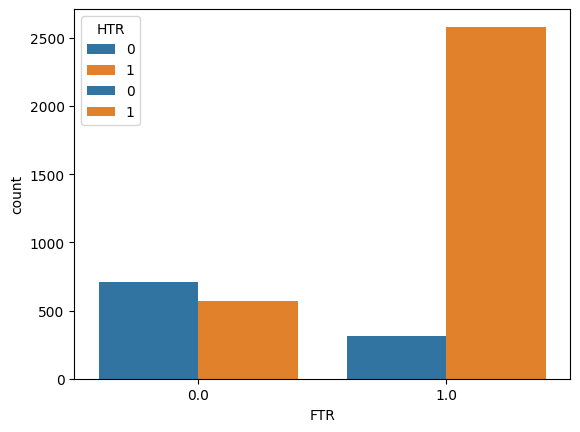

In [ ]:
#@title Анализ данных

# для построения графиков воспользуемся новой для нас библиотекой seaborn
import seaborn as sns


# зависимость не проигрыша от игры дома
sns.countplot(x = 'HomeTeam', hue = 'HTR', data = df_normalized)

# зависимость не проигрыша от непроирыша в пером тайме
sns.countplot(x = 'FTR', hue = 'HTR', data = df_normalized)

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

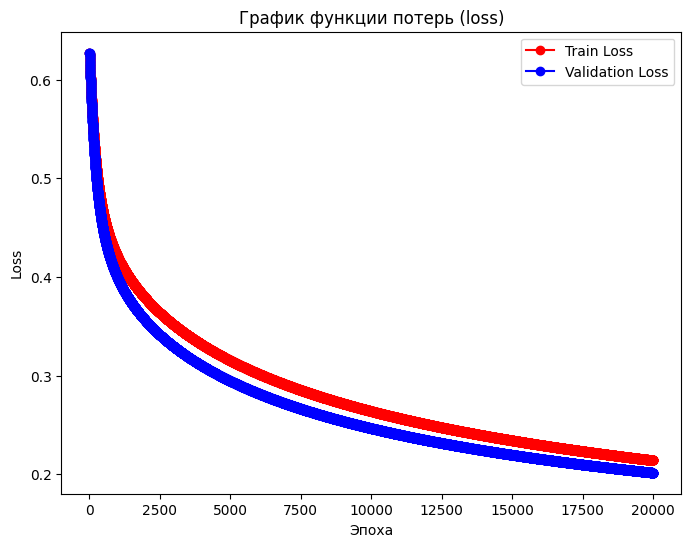

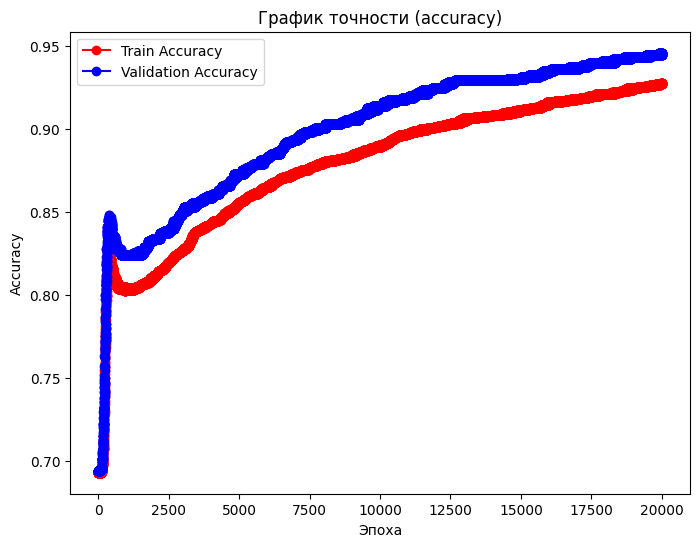

In [ ]:
#@title Создание и обучение модели, отрисовка графиков
# Assuming 'df' is your DataFrame containing the data
X = df_normalized.drop(columns=['FTR'])  # Drop the target column 'FTR' from the feature matrix
y = df_normalized['FTR']  # Extract the target column as the target vector

# Разделение данных на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели с warm_start=True
model = LogisticRegression(max_iter=1, warm_start=True)

# Инициализация списков для хранения значений функции потерь и точности
loss_values_train = []
accuracy_values_train = []
loss_values_val = []
accuracy_values_val = []

# Цикл обучения и записи значений на каждой эпохе
epochs = 20000  # Максимальное количество итераций
for epoch in range(epochs):
    model.fit(X_train, y_train)  # Обучение модели на одну эпоху

    # Вычисление функции потерь и точности для тренировочного набора
    loss_train = -np.mean(y_train * np.log(model.predict_proba(X_train)[:, 1]) + (1 - y_train) * np.log(1 - model.predict_proba(X_train)[:, 1]))
    accuracy_train = model.score(X_train, y_train)
    loss_values_train.append(loss_train)
    accuracy_values_train.append(accuracy_train)

    # Вычисление функции потерь и точности для валидационного набора
    loss_val = -np.mean(y_val * np.log(model.predict_proba(X_val)[:, 1]) + (1 - y_val) * np.log(1 - model.predict_proba(X_val)[:, 1]))
    accuracy_val = model.score(X_val, y_val)
    loss_values_val.append(loss_val)
    accuracy_values_val.append(accuracy_val)

# Построение графика функции потерь (loss) на каждой эпохе для тренировочной и валидационной выборки
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values_train, marker='o', color='red', label='Train Loss')
plt.plot(range(1, epochs + 1), loss_values_val, marker='o', color='blue', label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('График функции потерь (loss)')
plt.legend()
plt.show()

# Построение графика точности (accuracy) на каждой эпохе для тренировочной и валидационной выборки
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), accuracy_values_train, marker='o', color='red', label='Train Accuracy')
plt.plot(range(1, epochs + 1), accuracy_values_val, marker='o', color='blue', label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('График точности (accuracy)')
plt.legend()
plt.show()


# Нейросеть Dense

In [ ]:
# @title Проверка размерности

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3341, 19)
y_train: (3341,)

X_test: (380, 19)
y_test: (380,)


In [ ]:
# @title Перевод в Numpay массив
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test= np.array(X_test)
y_test = np.array(y_test)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3341, 19)
y_train: (3341,)

X_test: (380, 19)
y_test: (380,)


In [ ]:
# @title Нейросеть 1

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the neural network model
model = Sequential()
model.add(Dense(300, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(40, activation='tanh'))
model.add(Dense(60, activation='ReLU'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(3, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовом наборе:", accuracy)


Epoch 1/25
84/84 [==============================] - 3s 8ms/step - loss: 0.6561 - accuracy: 0.6280 - val_loss: 0.6350 - val_accuracy: 0.6697
Epoch 2/25
84/84 [==============================] - 0s 5ms/step - loss: 0.6138 - accuracy: 0.6987 - val_loss: 0.6352 - val_accuracy: 0.6697
Epoch 3/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6987 - val_loss: 0.6361 - val_accuracy: 0.6697
Epoch 4/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6121 - accuracy: 0.6987 - val_loss: 0.6360 - val_accuracy: 0.6697
Epoch 5/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6987 - val_loss: 0.6362 - val_accuracy: 0.6697
Epoch 6/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6122 - accuracy: 0.6987 - val_loss: 0.6371 - val_accuracy: 0.6697
Epoch 7/25
84/84 [==============================] - 0s 4ms/step - loss: 0.6123 - accuracy: 0.6987 - val_loss: 0.6363 - val_accuracy: 0.6697
Epoch 8/25
84/84 [==

In [ ]:
# @title Модель нейронной сети

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               6000      
                                                                 
 dense_1 (Dense)             (None, 60)                18060     
                                                                 
 dense_2 (Dense)             (None, 40)                2440      
                                                                 
 dense_3 (Dense)             (None, 60)                2460      
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
 dense_6 (Dense)             (None, 3)                 3

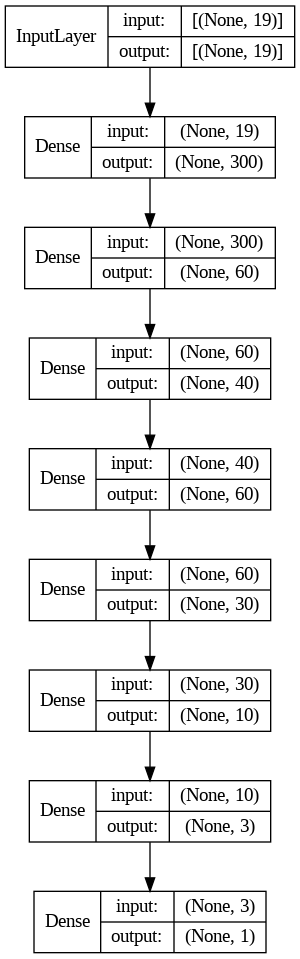

In [ ]:
# @title Схема нейросети

from tensorflow.keras import utils              # Утилиты для подготовки данных
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

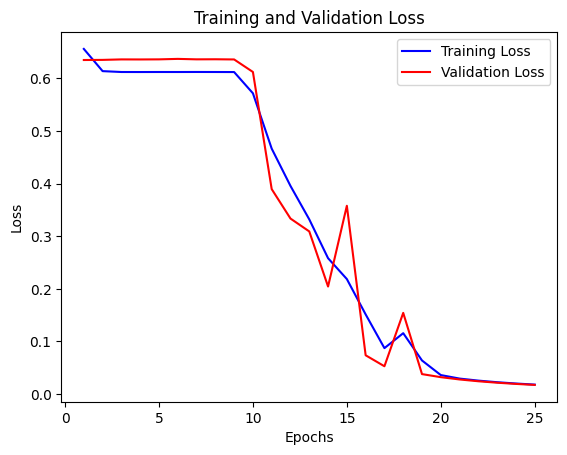

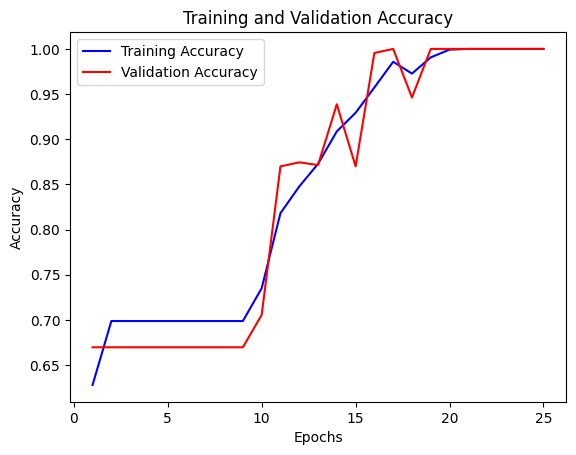

In [ ]:
# @title Вывод графиков

import matplotlib.pyplot as plt

# График функции потерь
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Нейросеть LSTM

In [ ]:
# @title Перевод в Numpay массив
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test= np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# @title Подготовка к корректной подаче в LSTM слой

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (3797, 1, 19)
X_test: (380, 1, 19)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam


# Создание модели
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Один выходной нейрон для бинарной классификации

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовом наборе:", accuracy)


Epoch 1/50
95/95 [==============================] - 4s 12ms/step - loss: 0.5523 - accuracy: 0.7600 - val_loss: 0.5189 - val_accuracy: 0.7539
Epoch 2/50
95/95 [==============================] - 0s 5ms/step - loss: 0.4488 - accuracy: 0.7886 - val_loss: 0.3780 - val_accuracy: 0.8553
Epoch 3/50
95/95 [==============================] - 1s 6ms/step - loss: 0.3387 - accuracy: 0.8525 - val_loss: 0.3109 - val_accuracy: 0.8421
Epoch 4/50
95/95 [==============================] - 1s 8ms/step - loss: 0.2606 - accuracy: 0.8861 - val_loss: 0.2234 - val_accuracy: 0.9132
Epoch 5/50
95/95 [==============================] - 1s 8ms/step - loss: 0.1703 - accuracy: 0.9341 - val_loss: 0.1300 - val_accuracy: 0.9632
Epoch 6/50
95/95 [==============================] - 1s 8ms/step - loss: 0.1008 - accuracy: 0.9730 - val_loss: 0.0852 - val_accuracy: 0.9908
Epoch 7/50
95/95 [==============================] - 1s 6ms/step - loss: 0.0486 - accuracy: 0.9967 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 8/50
95/95 [=

In [ ]:
# @title Модель нейронной сети

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                21504     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23,617
Trainable params: 23,617
Non-trainable params: 0
_________________________________________________________________


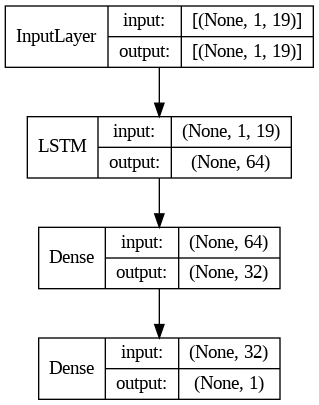

In [ ]:
# @title Схема нейросети

from tensorflow.keras import utils              # Утилиты для подготовки данных
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

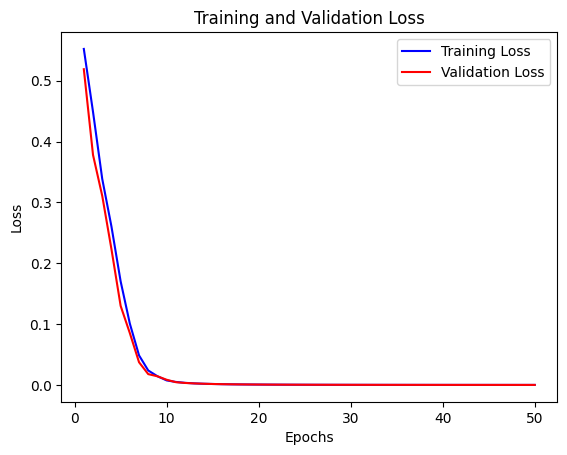

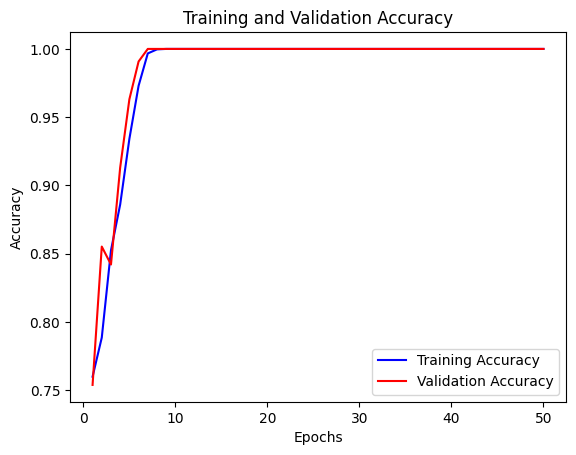

In [ ]:
# @title Построение графиков
import matplotlib.pyplot as plt

# График функции потерь
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Вывод: сеть с LSTM слоем учится быстрее чем с Dense, но обе достигают лучшего результатат на тестовой выборке чем сеть LogisticRegression

В качестве финальной версии берём версию с LSTM слоем и демонтсрируем её работу на тестовом наборе

In [ ]:
# @title Сохранение модели с весами
model.save("my_model_LSTM.h5")

12/12 [==============================] - 1s 3ms/step - loss: 2.5962 - accuracy: 0.8053
Test Loss: 2.5962138175964355
Test Accuracy: 0.8052631616592407
12/12 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.69      0.61        83
           1       0.91      0.84      0.87       297

    accuracy                           0.81       380
   macro avg       0.72      0.76      0.74       380
weighted avg       0.83      0.81      0.81       380



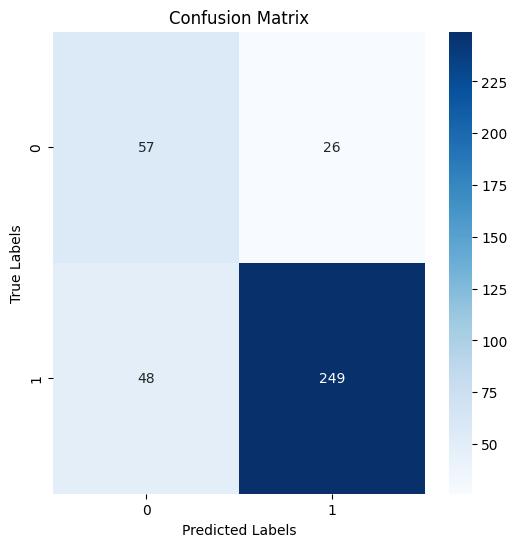

In [ ]:
# @title Проверка на тестовой выборке
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

loaded_model = load_model("my_model_LSTM.h5")

loss, accuracy = loaded_model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred = loaded_model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Выводы: получилось добиться большой точности. Дальнейшее работва по предсказанию результатов футбольных матчей может строиться на предсказании результата после двух таймов на основе результата первого тайма. Для реализации этой нейросети выбрать сеть с LSTM слоем.

# Усложнение задачи. Сделаем классификацию матчей на победа - поражение - ничья


---







# Подготовка БД любого размера для предсказания трёх результатов - выигрышь, поражение, ничья



**База данных для обучения строиться на основе чемпионатов Италии**

In [ ]:
# @title Подготовка объединённой таблицы

# Задайте путь к директории, которую нужно просканировать
directory_path = '/content/Italiy/'

# Список столбцов, которые нужно оставить
columns_to_keep = ['Date',	'HomeTeam',	'AwayTeam',	'FTHG',	'FTAG',	'FTR',	'HTHG',	'HTAG',	'HTR',	'HS',	'AS',	'HST',	'AST',
                   'HF',	'AF',	'HC',	'AC',	'HY',	'AY',	'HR',	'AR']

# Получите список всех файлов в директории
file_list = os.listdir(directory_path)

# Создаём объеденённую таблицу
df_join = []
df_join = pd.DataFrame(df_join)
# Переберите все файлы и выполните нужные действия
for file_name in file_list:
    # Получите полный путь к файлу
    file_path = os.path.join(directory_path, file_name)

    # Проверяем, является ли файл
    if os.path.isfile(file_path):
        # читаем файл
        data = pd.read_csv(file_path, encoding='cp1251', delimiter=',')
        # переводим в DataFrame
        df = pd.DataFrame(data)
        # переводим в DataFrame
        df = pd.DataFrame(data)
        # оставляем нужные колонки
        df = df.drop(columns=df.columns.difference(columns_to_keep))
        # Объединение данных всех таблиц
        df_join = pd.concat([df_join, df])
    else:
        print(f"{file_name} не является файлом данных и будет пропущен.")

# Вывод объединенной таблицы
print(df_join)
print(df_join.shape)


           Date   HomeTeam  AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR    HS  \
0      24/08/13  Sampdoria  Juventus   0.0   1.0   A   0.0   0.0   D   4.0   
1      24/08/13     Verona     Milan   2.0   1.0   H   1.0   1.0   D  14.0   
2      25/08/13   Cagliari  Atalanta   2.0   1.0   H   1.0   1.0   D  23.0   
3      25/08/13      Inter     Genoa   2.0   0.0   H   0.0   0.0   D  20.0   
4      25/08/13      Lazio   Udinese   2.0   1.0   H   2.0   0.0   H  20.0   
..          ...        ...       ...   ...   ...  ..   ...   ...  ..   ...   
375  26/05/2019      Inter    Empoli   2.0   1.0   H   0.0   0.0   D  20.0   
376  26/05/2019       Roma     Parma   2.0   1.0   H   1.0   0.0   H  16.0   
377  26/05/2019  Sampdoria  Juventus   2.0   0.0   H   0.0   0.0   D  10.0   
378  26/05/2019       Spal     Milan   2.0   3.0   A   1.0   2.0   A   7.0   
379  26/05/2019     Torino     Lazio   3.0   1.0   H   0.0   0.0   D   9.0   

     ...   HST  AST    HF    AF    HC    AC   HY   AY   HR   AR

In [ ]:
# @title Выявим пропущенные значения и удалим их

# выявим пропущенные значения с помощью .isnull() и посчитаем их количество через sum()
print(df_join.isnull().sum())
print()
print()
# удаление пустых значений
df_join.dropna(inplace=True)
print(df_join.isnull().sum())

Date        5
HomeTeam    5
AwayTeam    5
FTHG        5
FTAG        5
FTR         5
HTHG        7
HTAG        7
HTR         7
HS          6
AS          6
HST         6
AST         6
HF          6
AF          6
HC          6
AC          6
HY          7
AY          6
HR          6
AR          6
dtype: int64


Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


In [ ]:
df_join[1000:1010]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
241,12/02/16,Carpi,Roma,1.0,3.0,A,0.0,0.0,D,7.0,...,2.0,6.0,14.0,8.0,4.0,6.0,5.0,0.0,0.0,0.0
242,13/02/16,Chievo,Sassuolo,1.0,1.0,D,1.0,1.0,D,11.0,...,4.0,2.0,16.0,14.0,5.0,7.0,3.0,2.0,0.0,0.0
243,13/02/16,Empoli,Frosinone,1.0,2.0,A,0.0,1.0,A,29.0,...,6.0,2.0,11.0,25.0,16.0,1.0,2.0,6.0,0.0,0.0
244,13/02/16,Juventus,Napoli,1.0,0.0,H,0.0,0.0,D,13.0,...,4.0,1.0,10.0,13.0,4.0,3.0,2.0,2.0,0.0,0.0
245,14/02/16,Fiorentina,Inter,2.0,1.0,H,0.0,1.0,A,13.0,...,8.0,1.0,13.0,14.0,7.0,4.0,2.0,5.0,1.0,2.0
246,14/02/16,Milan,Genoa,2.0,1.0,H,1.0,0.0,H,14.0,...,6.0,2.0,14.0,15.0,5.0,3.0,1.0,1.0,0.0,0.0
247,14/02/16,Palermo,Torino,1.0,3.0,A,1.0,2.0,A,18.0,...,5.0,8.0,12.0,22.0,9.0,3.0,1.0,2.0,0.0,0.0
248,14/02/16,Sampdoria,Atalanta,0.0,0.0,D,0.0,0.0,D,10.0,...,2.0,2.0,10.0,15.0,7.0,6.0,2.0,4.0,0.0,0.0
249,14/02/16,Udinese,Bologna,0.0,1.0,A,0.0,0.0,D,10.0,...,2.0,2.0,15.0,11.0,8.0,6.0,0.0,1.0,0.0,0.0
250,19/02/16,Bologna,Juventus,0.0,0.0,D,0.0,0.0,D,8.0,...,1.0,0.0,15.0,11.0,1.0,8.0,2.0,2.0,0.0,0.0


In [ ]:
# @title Удаляем столбец дата т.к. данные идут в порядке увеличения дат

df_join = df_join.drop('Date', axis=1)

In [ ]:
# @title Замена значений в столбцах FTR и HTR

df_join['FTR'] = df_join['FTR'].replace({'A': 0, 'H': 2, 'D': 1})
df_join['HTR'] = df_join['HTR'].replace({'A': 0, 'H': 2, 'D': 1})

print(df_join)


      HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR    HS    AS   HST  \
0    Sampdoria  Juventus   0.0   1.0    0   0.0   0.0    1   4.0  11.0   1.0   
1       Verona     Milan   2.0   1.0    2   1.0   1.0    1  14.0  15.0   8.0   
2     Cagliari  Atalanta   2.0   1.0    2   1.0   1.0    1  23.0  11.0   7.0   
3        Inter     Genoa   2.0   0.0    2   0.0   0.0    1  20.0   4.0   5.0   
4        Lazio   Udinese   2.0   1.0    2   2.0   0.0    2  20.0   7.0   6.0   
..         ...       ...   ...   ...  ...   ...   ...  ...   ...   ...   ...   
375      Inter    Empoli   2.0   1.0    2   0.0   0.0    1  20.0   9.0  15.0   
376       Roma     Parma   2.0   1.0    2   1.0   0.0    2  16.0   9.0   8.0   
377  Sampdoria  Juventus   2.0   0.0    2   0.0   0.0    1  10.0   6.0   3.0   
378       Spal     Milan   2.0   3.0    0   1.0   2.0    0   7.0  16.0   4.0   
379     Torino     Lazio   3.0   1.0    2   0.0   0.0    1   9.0   9.0   7.0   

     AST    HF    AF    HC    AC   HY  

In [ ]:
# @title Замена названий команд на цифры

# Создание множества футбольных комманд
set_commands = set()
for index, value in enumerate(df_join['HomeTeam']):
  set_commands.add(value)
set_commands = set(df_join['HomeTeam'].astype(str))
set_commands_sorted = sorted(set_commands)

print(set_commands_sorted)
print(len(set_commands_sorted))

# Создание словаря соответствий
mapping = {}
for i, k in enumerate(set_commands_sorted):
  mapping[k] = i
print(mapping)
print()
# Замена значений названий комманд в столбцах с использованием словаря
df_join['HomeTeam'] = df_join['HomeTeam'].replace(mapping)
df_join['AwayTeam'] = df_join['AwayTeam'].replace(mapping)
print(df_join)

['Atalanta', 'Benevento', 'Bologna', 'Brescia', 'Cagliari', 'Carpi', 'Catania', 'Cesena', 'Chievo', 'Crotone', 'Empoli', 'Fiorentina', 'Frosinone', 'Genoa', 'Inter', 'Juventus', 'Lazio', 'Lecce', 'Livorno', 'Milan', 'Napoli', 'Novara', 'Palermo', 'Parma', 'Pescara', 'Roma', 'Salernitana', 'Sampdoria', 'Sassuolo', 'Siena', 'Spal', 'Spezia', 'Torino', 'Udinese', 'Venezia', 'Verona']
36
{'Atalanta': 0, 'Benevento': 1, 'Bologna': 2, 'Brescia': 3, 'Cagliari': 4, 'Carpi': 5, 'Catania': 6, 'Cesena': 7, 'Chievo': 8, 'Crotone': 9, 'Empoli': 10, 'Fiorentina': 11, 'Frosinone': 12, 'Genoa': 13, 'Inter': 14, 'Juventus': 15, 'Lazio': 16, 'Lecce': 17, 'Livorno': 18, 'Milan': 19, 'Napoli': 20, 'Novara': 21, 'Palermo': 22, 'Parma': 23, 'Pescara': 24, 'Roma': 25, 'Salernitana': 26, 'Sampdoria': 27, 'Sassuolo': 28, 'Siena': 29, 'Spal': 30, 'Spezia': 31, 'Torino': 32, 'Udinese': 33, 'Venezia': 34, 'Verona': 35}

     HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR    HS    AS   HST  \
0          27  

In [ ]:
#@title Нормализация

from sklearn.preprocessing import MinMaxScaler


# Создание копий столбцов, которые будут исключены из нормализации. И сброс их индексов
ftr_column = df_join['FTR'].copy().reset_index(drop=True)
htr_column = df_join['HTR'].copy().reset_index(drop=True)
home_team_column = df_join['HomeTeam'].copy().reset_index(drop=True)
away_team_column = df_join['AwayTeam'].copy().reset_index(drop=True)

# Удаление столбцов, которые не будут нормализованы
columns_to_normalize = df_join.drop(['FTR', 'HTR', 'HomeTeam', 'AwayTeam'], axis=1)

# Нормализация данных
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(columns_to_normalize), columns = columns_to_normalize.columns)

# Добавление столбцов обратно к нормализованным данным
df_normalized['FTR'] = ftr_column
df_normalized['HTR'] = htr_column
df_normalized['HomeTeam'] = home_team_column
df_normalized['AwayTeam'] = away_team_column

# Вывод нормализованной таблицы
print(df_normalized)

          FTHG      FTAG  HTHG  HTAG        HS        AS       HST     AST  \
0     0.000000  0.142857   0.0   0.0  0.066667  0.354839  0.055556  0.2500   
1     0.285714  0.142857   0.2   0.2  0.288889  0.483871  0.444444  0.3125   
2     0.285714  0.142857   0.2   0.2  0.488889  0.354839  0.388889  0.1250   
3     0.285714  0.000000   0.0   0.0  0.422222  0.129032  0.277778  0.0000   
4     0.285714  0.142857   0.4   0.0  0.422222  0.225806  0.333333  0.1875   
...        ...       ...   ...   ...       ...       ...       ...     ...   
3792  0.285714  0.142857   0.0   0.0  0.422222  0.290323  0.833333  0.3125   
3793  0.285714  0.142857   0.2   0.0  0.333333  0.290323  0.444444  0.3125   
3794  0.285714  0.000000   0.0   0.0  0.200000  0.193548  0.166667  0.0625   
3795  0.285714  0.428571   0.2   0.4  0.133333  0.516129  0.222222  0.5000   
3796  0.428571  0.142857   0.0   0.0  0.177778  0.290323  0.388889  0.2500   

            HF        AF        HC        AC        HY     AY  

In [ ]:
# @title Приминение one-hot encoding к столбцам HomeTeam	и AwayTeam т.е. к названиям комманд
pd.get_dummies(df_normalized['HomeTeam']).head()
pd.get_dummies(df_normalized['AwayTeam']).head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# @title Создание тренировочного набора

# поместим в X_train все кроме столбца HTR
X_train = df_normalized.drop('HTR', axis = 1)

# столбец 'HTR' станет нашей целевой переменной (y_train)
y_train = df_normalized['HTR']

print(X_train.shape)
print(y_train.shape)

(3797, 19)
(3797,)


In [ ]:
# @title Перевод в Numpay массив
X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(3797, 19)
(3797,)


# Подготовка тестового набора для предсказания трёх результатов - выигрышь, поражение, ничья

**Тестовый набор берётся с чемпионата Испании сезона 2019-2020 гг.**


In [ ]:
# @title Скачивание файла с тестовыми данными

test = pd.read_csv('/content/Spain_2019_2020.csv', encoding = 'cp1251', delimiter=',')

# Мой DataFrame
test_df = pd.DataFrame(test)  # Код для создания DataFrame


  # Список столбцов, которые нужно оставить
columns_to_keep = ['Date',	'HomeTeam',	'AwayTeam',	'FTHG',	'FTAG',	'FTR',	'HTHG',	'HTAG',	'HTR',	'HS',	'AS',
                   'HST',	'AST', 'HF',	'AF',	'HC',	'AC',	'HY',	'AY',	'HR',	'AR']  # Столбцы которые нужно оставить

  # Удаление всех столбцов, кроме указанных
test_df = test_df.drop(columns = test_df.columns.difference(columns_to_keep))

# Замена значений в столбце 'Столбец1'
test_df['FTR'] = test_df['FTR'].replace({'A': 0, 'H': 2, 'D': 1})
test_df['HTR'] = test_df['HTR'].replace({'A': 0, 'H': 2, 'D': 1})

print(test_df)

           Date    HomeTeam     AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR  \
0    16/08/2019  Ath Bilbao    Barcelona     1     0    2     0     0    1   
1    17/08/2019       Celta  Real Madrid     1     3    0     0     1    0   
2    17/08/2019    Valencia     Sociedad     1     1    1     0     0    1   
3    17/08/2019    Mallorca        Eibar     2     1    2     1     0    2   
4    17/08/2019     Leganes      Osasuna     0     1    0     0     0    1   
..          ...         ...          ...   ...   ...  ...   ...   ...  ...   
375  19/07/2020     Granada   Ath Bilbao     4     0    2     1     0    2   
376  19/07/2020     Leganes  Real Madrid     2     2    1     1     1    1   
377  19/07/2020     Levante       Getafe     1     0    2     0     0    1   
378  19/07/2020     Osasuna     Mallorca     2     2    1     1     1    1   
379  19/07/2020     Sevilla     Valencia     1     0    2     0     0    1   

     HS  ...  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0    1

In [ ]:
# выявим пропущенные значения с помощью .isnull() и посчитаем их количество через sum()
test_df.isnull().sum()
# удвление пустых значений
test_df.dropna(inplace=True)
test_df.isnull().sum()

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

In [ ]:
# @title Создание множества футбольных комманд
set_commands = set()
for index, value in enumerate(test_df['HomeTeam']):
  set_commands.add(value)
set_commands = set(test_df['HomeTeam'].astype(str))
set_commands_sorted = sorted(set_commands)
#set_commands_sorted.remove('nan')
print(set_commands_sorted)
print(len(set_commands_sorted))

# Создание словаря соответствий
mapping = {}
for i, k in enumerate(set_commands_sorted):
  mapping[k] = i
print(mapping)

# Замена значений названий комманд в столбцах с использованием словаря
test_df['HomeTeam'] = test_df['HomeTeam'].replace(mapping)
test_df['AwayTeam'] = test_df['AwayTeam'].replace(mapping)
print(test_df)

# Удаляем столбез дата т.к. данные идут в порядке увеличения дат
test_df = test_df.drop('Date', axis=1)
test_df

['Alaves', 'Ath Bilbao', 'Ath Madrid', 'Barcelona', 'Betis', 'Celta', 'Eibar', 'Espanol', 'Getafe', 'Granada', 'Leganes', 'Levante', 'Mallorca', 'Osasuna', 'Real Madrid', 'Sevilla', 'Sociedad', 'Valencia', 'Valladolid', 'Villarreal']
20
{'Alaves': 0, 'Ath Bilbao': 1, 'Ath Madrid': 2, 'Barcelona': 3, 'Betis': 4, 'Celta': 5, 'Eibar': 6, 'Espanol': 7, 'Getafe': 8, 'Granada': 9, 'Leganes': 10, 'Levante': 11, 'Mallorca': 12, 'Osasuna': 13, 'Real Madrid': 14, 'Sevilla': 15, 'Sociedad': 16, 'Valencia': 17, 'Valladolid': 18, 'Villarreal': 19}
           Date  HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR  HS  \
0    16/08/2019         1         3     1     0    2     0     0    1  11   
1    17/08/2019         5        14     1     3    0     0     1    0   7   
2    17/08/2019        17        16     1     1    1     0     0    1  14   
3    17/08/2019        12         6     2     1    2     1     0    2  16   
4    17/08/2019        10        13     0     1    0     0     0    1  13 

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,3,1,0,2,0,0,1,11,11,5,2,14,9,3,8,1,1,0,0
1,5,14,1,3,0,0,1,0,7,17,4,11,17,12,6,4,5,2,0,1
2,17,16,1,1,1,0,0,1,14,12,6,3,13,14,3,3,4,4,1,0
3,12,6,2,1,2,1,0,2,16,11,4,5,13,14,9,3,2,3,0,0
4,10,13,0,1,0,0,0,1,13,4,2,2,17,11,8,0,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,9,1,4,0,2,1,0,2,11,11,6,3,10,11,2,3,1,2,0,0
376,10,14,2,2,1,1,1,1,15,7,7,4,9,11,5,2,4,1,0,0
377,11,8,1,0,2,0,0,1,13,13,4,4,10,12,6,8,2,4,0,0
378,13,12,2,2,1,1,1,1,12,12,5,4,17,10,3,5,2,0,0,0


In [ ]:
#@title Нормализация тестовых данных

from sklearn.preprocessing import MinMaxScaler
# Создание копий столбцов, которые будут исключены из нормализации. И сброс их индексов
ftr_column = test_df['FTR'].copy().reset_index(drop=True)
htr_column = test_df['HTR'].copy().reset_index(drop=True)
home_team_column = test_df['HomeTeam'].copy().reset_index(drop=True)
away_team_column = test_df['AwayTeam'].copy().reset_index(drop=True)

# Удаление столбцов, которые не будут нормализованы
columns_to_normalize = test_df.drop(['FTR', 'HTR', 'HomeTeam', 'AwayTeam'], axis=1)

# Нормализация данных
scaler = MinMaxScaler()
test_df_normalized = pd.DataFrame(scaler.fit_transform(columns_to_normalize), columns=columns_to_normalize.columns)

# Добавление столбцов обратно к нормализованным данным
test_df_normalized['FTR'] = ftr_column
test_df_normalized['HTR'] = htr_column
test_df_normalized['HomeTeam'] = home_team_column
test_df_normalized['AwayTeam'] = away_team_column

# Вывод нормализованной таблицы
print(test_df_normalized)

         FTHG  FTAG  HTHG      HTAG        HS        AS       HST       AST  \
0    0.166667   0.0  0.00  0.000000  0.363636  0.434783  0.294118  0.166667   
1    0.166667   0.6  0.00  0.333333  0.181818  0.695652  0.235294  0.916667   
2    0.166667   0.2  0.00  0.000000  0.500000  0.478261  0.352941  0.250000   
3    0.333333   0.2  0.25  0.000000  0.590909  0.434783  0.235294  0.416667   
4    0.000000   0.2  0.00  0.000000  0.454545  0.130435  0.117647  0.166667   
..        ...   ...   ...       ...       ...       ...       ...       ...   
375  0.666667   0.0  0.25  0.000000  0.363636  0.434783  0.352941  0.250000   
376  0.333333   0.4  0.25  0.333333  0.545455  0.260870  0.411765  0.333333   
377  0.166667   0.0  0.00  0.000000  0.454545  0.521739  0.235294  0.333333   
378  0.333333   0.4  0.25  0.333333  0.409091  0.478261  0.294118  0.333333   
379  0.166667   0.0  0.00  0.000000  0.590909  0.304348  0.235294  0.166667   

           HF    AF        HC        AC        HY  

In [ ]:
# @title Приминение one-hot encoding к столбцам HomeTeam	и AwayTeam т.е. к названиям комманд

pd.get_dummies(test_df_normalized['HomeTeam']).head()
pd.get_dummies(test_df_normalized['AwayTeam']).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#@title Разделение тестовой выборки на признаки (X_test) и целевую переменную (y_test)

# поместим в X_test все кроме столбца HTR
X_test = test_df_normalized.drop('HTR', axis = 1)

# столбец 'HTR' станет нашей целевой переменной (y_test)
y_test = test_df_normalized['HTR']

print(X_test.shape)
print(y_test.shape)

(380, 19)
(380,)


# Формирование валидационной выборки

In [ ]:
# @title Подготовка объединённой таблицы

# Задайте путь к директории, которую нужно просканировать
directory_path_val = '/content/France/'

# Список столбцов, которые нужно оставить
columns_to_keep_val = ['Date',	'HomeTeam',	'AwayTeam',	'FTHG',	'FTAG',	'FTR',	'HTHG',	'HTAG',	'HTR',	'HS',	'AS',	'HST',	'AST',
                   'HF',	'AF',	'HC',	'AC',	'HY',	'AY',	'HR',	'AR']

# Получите список всех файлов в директории
file_list_val = os.listdir(directory_path_val)

# Создаём объеденённую таблицу
df_join_val = []
df_join_val = pd.DataFrame(df_join_val)
# Переберите все файлы и выполните нужные действия
for file_name in file_list_val:
    # Получите полный путь к файлу
    file_path = os.path.join(directory_path_val, file_name)

    # Проверяем, является ли файл
    if os.path.isfile(file_path):
        # читаем файл
        data = pd.read_csv(file_path, encoding='cp1251', delimiter=',')
        # переводим в DataFrame
        df = pd.DataFrame(data)
        # переводим в DataFrame
        df = pd.DataFrame(data)
        # оставляем нужные колонки
        df = df.drop(columns=df.columns.difference(columns_to_keep))
        # Объединение данных всех таблиц
        df_join_val = pd.concat([df_join_val, df])
    else:
        print(f"{file_name} не является файлом данных и будет пропущен.")

# Вывод объединенной таблицы
print(df_join_val)
print(df_join_val.shape)

           Date    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  \
0    06/08/2021      Monaco       Nantes     1     1   D     1     1   D  15   
1    07/08/2021        Lyon        Brest     1     1   D     0     1   A  17   
2    07/08/2021      Troyes     Paris SG     1     2   A     1     2   A  15   
3    08/08/2021      Rennes         Lens     1     1   D     1     1   D  10   
4    08/08/2021    Bordeaux     Clermont     0     2   A     0     0   D  10   
..          ...         ...          ...   ...   ...  ..   ...   ...  ..  ..   
375  23/05/2021      Nantes  Montpellier     1     2   A     1     1   D  15   
376  23/05/2021       Reims     Bordeaux     1     2   A     1     1   D  10   
377  23/05/2021      Rennes        Nimes     2     0   H     1     0   H  13   
378  23/05/2021  St Etienne        Dijon     0     1   A     0     1   A  19   
379  23/05/2021  Strasbourg      Lorient     1     1   D     1     0   H   6   

     ...  HST  AST  HF  AF  HC  AC  HY 

In [ ]:
# @title Выявим пропущенные значения и удалим их

# выявим пропущенные значения с помощью .isnull() и посчитаем их количество через sum()
print(df_join_val.isnull().sum())
print()
print()
# удаление пустых значений
df_join_val.dropna(inplace=True)
print(df_join_val.isnull().sum())

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


In [ ]:
# @title Удаляем столбец дата т.к. данные идут в порядке увеличения дат

df_join_val = df_join_val.drop('Date', axis=1)

In [ ]:
# @title Замена значений в столбцах FTR и HTR

df_join_val['FTR'] = df_join_val['FTR'].replace({'A': 0, 'H': 2, 'D': 1})
df_join_val['HTR'] = df_join_val['HTR'].replace({'A': 0, 'H': 2, 'D': 1})

print(df_join_val)

       HomeTeam     AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR  HS  AS  HST  \
0        Monaco       Nantes     1     1    1     1     1    1  15   5    3   
1          Lyon        Brest     1     1    1     0     1    0  17  13    4   
2        Troyes     Paris SG     1     2    0     1     2    0  15  12    7   
3        Rennes         Lens     1     1    1     1     1    1  10  11    2   
4      Bordeaux     Clermont     0     2    0     0     0    1  10  19    6   
..          ...          ...   ...   ...  ...   ...   ...  ...  ..  ..  ...   
375      Nantes  Montpellier     1     2    0     1     1    1  15   8    5   
376       Reims     Bordeaux     1     2    0     1     1    1  10  12    3   
377      Rennes        Nimes     2     0    2     1     0    2  13   9    6   
378  St Etienne        Dijon     0     1    0     0     1    0  19  10    5   
379  Strasbourg      Lorient     1     1    1     1     0    2   6   7    2   

     AST  HF  AF  HC  AC  HY  AY  HR  AR  
0      1

In [ ]:
# @title Замена названий команд на цифры

# Создание множества футбольных комманд
set_commands = set()
for index, value in enumerate(df_join_val['HomeTeam']):
  set_commands.add(value)
set_commands = set(df_join_val['HomeTeam'].astype(str))
set_commands_sorted = sorted(set_commands)

print(set_commands_sorted)
print(len(set_commands_sorted))

# Создание словаря соответствий
mapping = {}
for i, k in enumerate(set_commands_sorted):
  mapping[k] = i
print(mapping)
print()
# Замена значений названий комманд в столбцах с использованием словаря
df_join_val['HomeTeam'] = df_join_val['HomeTeam'].replace(mapping)
df_join_val['AwayTeam'] = df_join_val['AwayTeam'].replace(mapping)
print(df_join_val)

['Ajaccio', 'Amiens', 'Angers', 'Auxerre', 'Bordeaux', 'Brest', 'Clermont', 'Dijon', 'Lens', 'Lille', 'Lorient', 'Lyon', 'Marseille', 'Metz', 'Monaco', 'Montpellier', 'Nantes', 'Nice', 'Nimes', 'Paris SG', 'Reims', 'Rennes', 'St Etienne', 'Strasbourg', 'Toulouse', 'Troyes']
26
{'Ajaccio': 0, 'Amiens': 1, 'Angers': 2, 'Auxerre': 3, 'Bordeaux': 4, 'Brest': 5, 'Clermont': 6, 'Dijon': 7, 'Lens': 8, 'Lille': 9, 'Lorient': 10, 'Lyon': 11, 'Marseille': 12, 'Metz': 13, 'Monaco': 14, 'Montpellier': 15, 'Nantes': 16, 'Nice': 17, 'Nimes': 18, 'Paris SG': 19, 'Reims': 20, 'Rennes': 21, 'St Etienne': 22, 'Strasbourg': 23, 'Toulouse': 24, 'Troyes': 25}

     HomeTeam  AwayTeam  FTHG  FTAG  FTR  HTHG  HTAG  HTR  HS  AS  HST  AST  \
0          14        16     1     1    1     1     1    1  15   5    3    1   
1          11         5     1     1    1     0     1    0  17  13    4    8   
2          25        19     1     2    0     1     2    0  15  12    7    3   
3          21         8     1     1 

In [ ]:
#@title Нормализация

from sklearn.preprocessing import MinMaxScaler


# Создание копий столбцов, которые будут исключены из нормализации. И сброс их индексов
ftr_column = df_join_val['FTR'].copy().reset_index(drop=True)
htr_column = df_join_val['HTR'].copy().reset_index(drop=True)
home_team_column = df_join_val['HomeTeam'].copy().reset_index(drop=True)
away_team_column = df_join_val['AwayTeam'].copy().reset_index(drop=True)

# Удаление столбцов, которые не будут нормализованы
columns_to_normalize = df_join_val.drop(['FTR', 'HTR', 'HomeTeam', 'AwayTeam'], axis=1)

# Нормализация данных
scaler = MinMaxScaler()
df_normalized_val = pd.DataFrame(scaler.fit_transform(columns_to_normalize), columns = columns_to_normalize.columns)

# Добавление столбцов обратно к нормализованным данным
df_normalized_val['FTR'] = ftr_column
df_normalized_val['HTR'] = htr_column
df_normalized_val['HomeTeam'] = home_team_column
df_normalized_val['AwayTeam'] = away_team_column

# Вывод нормализованной таблицы
print(df_normalized_val)

          FTHG      FTAG  HTHG  HTAG       HS        AS       HST       AST  \
0     0.142857  0.142857   0.2   0.2  0.40625  0.161290  0.230769  0.066667   
1     0.142857  0.142857   0.0   0.2  0.46875  0.419355  0.307692  0.533333   
2     0.142857  0.285714   0.2   0.4  0.40625  0.387097  0.538462  0.200000   
3     0.142857  0.142857   0.2   0.2  0.25000  0.354839  0.153846  0.400000   
4     0.000000  0.285714   0.0   0.0  0.25000  0.612903  0.461538  0.666667   
...        ...       ...   ...   ...      ...       ...       ...       ...   
1414  0.142857  0.285714   0.2   0.2  0.40625  0.258065  0.384615  0.333333   
1415  0.142857  0.285714   0.2   0.2  0.25000  0.387097  0.230769  0.333333   
1416  0.285714  0.000000   0.2   0.0  0.34375  0.290323  0.461538  0.133333   
1417  0.000000  0.142857   0.0   0.2  0.53125  0.322581  0.384615  0.133333   
1418  0.142857  0.142857   0.2   0.0  0.12500  0.225806  0.153846  0.066667   

            HF        AF        HC        AC       

In [ ]:
# @title Приминение one-hot encoding к столбцам HomeTeam	и AwayTeam т.е. к названиям комманд
pd.get_dummies(df_normalized_val['HomeTeam']).head()
pd.get_dummies(df_normalized_val['AwayTeam']).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# @title Создание валидационного набора

# поместим в X_train все кроме столбца HTR
X_val = df_normalized_val.drop('HTR', axis = 1)

# столбец 'HTR' станет нашей целевой переменной (y_train)
y_val = df_normalized_val['HTR']

print(X_val.shape)
print(y_val.shape)

(1419, 19)
(1419,)


In [ ]:
# @title Перевод в Numpay массив
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_val.shape)
print(y_val.shape)

(1419, 19)
(1419,)


# Нейросеть на основе Dense слоёв для предсказания трёх результатов - выигрышь, поражение, ничья

In [ ]:
# @title Проверка размерности

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3797, 19)
y_train: (3797,)

X_test: (380, 19)
y_test: (380,)


In [ ]:
# @title Перевод в Numpay массив
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test= np.array(X_test)
y_test = np.array(y_test)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print()
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3797, 19)
y_train: (3797,)

X_test: (380, 19)
y_test: (380,)


In [ ]:
# @title Нейросеть 1

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the neural network model
model = Sequential()
model.add(Dense(300, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(40, activation='tanh'))
model.add(Dense(60, activation='ReLU'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовом наборе:", accuracy)


Epoch 1/25
119/119 [==============================] - 2s 6ms/step - loss: 0.9902 - accuracy: 0.4904 - val_loss: 0.8645 - val_accuracy: 0.6054
Epoch 2/25
119/119 [==============================] - 0s 3ms/step - loss: 0.7847 - accuracy: 0.6629 - val_loss: 0.6552 - val_accuracy: 0.7970
Epoch 3/25
119/119 [==============================] - 0s 3ms/step - loss: 0.4030 - accuracy: 0.9352 - val_loss: 0.2317 - val_accuracy: 1.0000
Epoch 4/25
119/119 [==============================] - 0s 3ms/step - loss: 0.1659 - accuracy: 1.0000 - val_loss: 0.1261 - val_accuracy: 1.0000
Epoch 5/25
119/119 [==============================] - 0s 3ms/step - loss: 0.1009 - accuracy: 1.0000 - val_loss: 0.0849 - val_accuracy: 1.0000
Epoch 6/25
119/119 [==============================] - 0s 3ms/step - loss: 0.0710 - accuracy: 1.0000 - val_loss: 0.0622 - val_accuracy: 1.0000
Epoch 7/25
119/119 [==============================] - 0s 3ms/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 1.0000
Epoch 

In [ ]:
# @title Модель нейронной сети

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               6000      
                                                                 
 dense_1 (Dense)             (None, 60)                18060     
                                                                 
 dense_2 (Dense)             (None, 40)                2440      
                                                                 
 dense_3 (Dense)             (None, 60)                2460      
                                                                 
 dense_4 (Dense)             (None, 30)                1830      
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
 dense_6 (Dense)             (None, 3)                 3

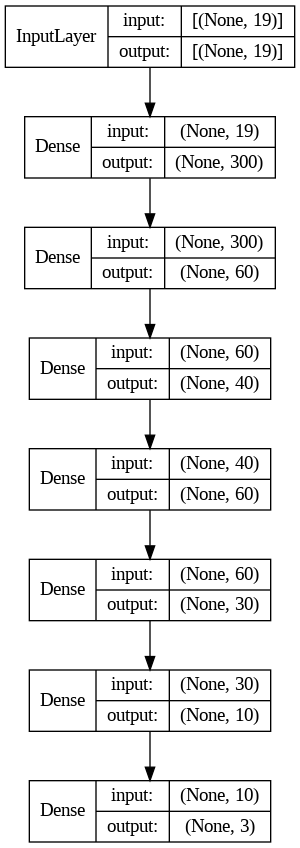

In [ ]:
# @title Схема нейросети

from tensorflow.keras import utils              # Утилиты для подготовки данных
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

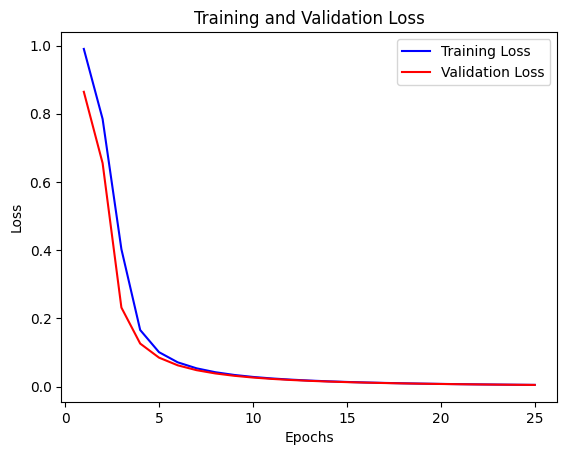

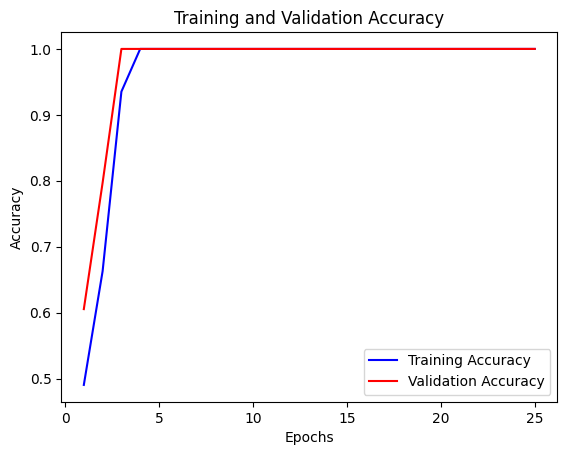

In [ ]:
# @title Вывод графиков

import matplotlib.pyplot as plt

# График функции потерь
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

12/12 [==============================] - 0s 2ms/step - loss: 0.2019 - accuracy: 0.9421
Точность на тестовом наборе: 0.942105233669281


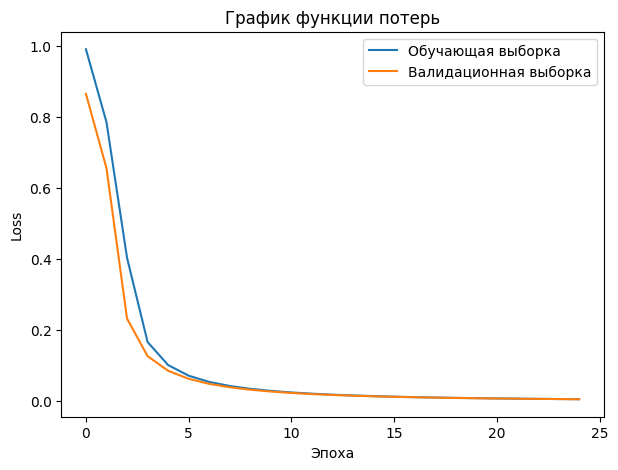

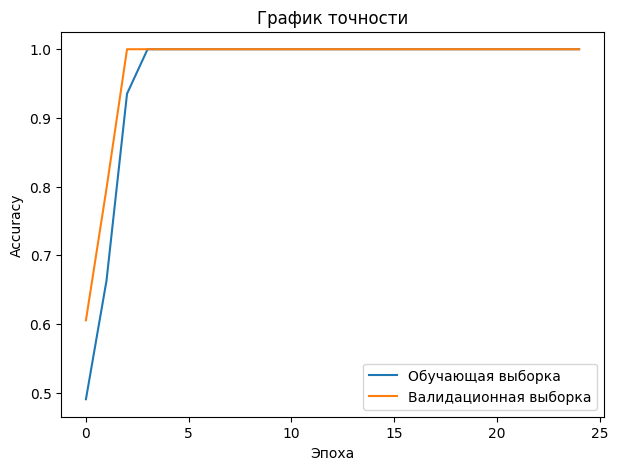

In [ ]:
# @title Проверки и графики для тестового набора

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Точность на тестовом наборе:", test_accuracy)

# Построение графика функции потерь на обучающей и валидационной выборке
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.legend()
plt.show()

# Построение графика точности на обучающей и валидационной выборке
plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('График точности')
plt.legend()
plt.show()


12/12 [==============================] - 0s 2ms/step


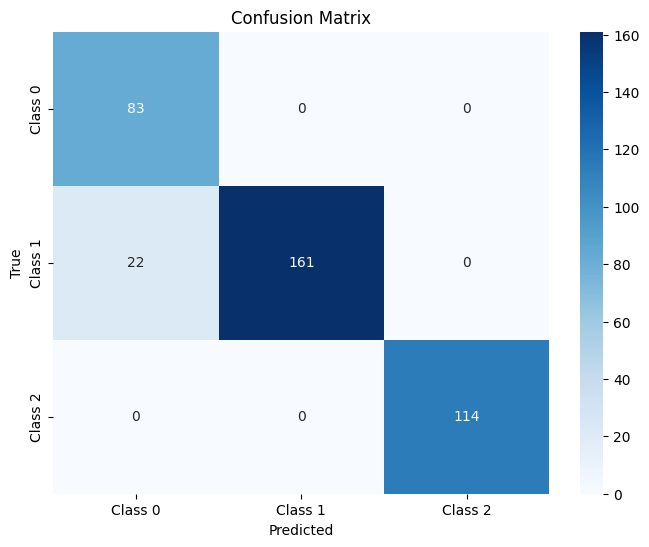

In [ ]:
# @title Матрица ошибок на тестовом наборе

# Получите предсказанные метки классов
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

# Вычислите матрицу ошибок
confusion_mtx = confusion_matrix(y_test, y_pred_class)

# Построение матрицы ошибок в виде тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Выводы: как интуитивно понятно, сеть чаще ошибается при предсказании ничейных результатов**